In [32]:
import requests
import warnings
import math
import numpy as np
import matplotlib.pyplot as plt
import time
warnings.filterwarnings('ignore')

In [33]:
def exponential_cdf(lmbda, time):
    return 1 - math.exp(-lmbda * time)

In [34]:
class FlakyClient:
    def __init__(self, base_url):
        self._base_url = base_url

    def call_status(self):
        response = requests.get(f"{self._base_url}/CircuitBreaker/Status", verify=False)
        return response.status_code, response.json()

    def call_reset(self):
        response = requests.get(f"{self._base_url}/CircuitBreaker/Reset", verify=False)
        return response.status_code

    def call_settings(self):
        response = requests.get(f"{self._base_url}/CircuitBreaker/Settings", verify=False)
        return response.status_code, response.json()

In [53]:
flaky_client = FlakyClient(base_url="https://localhost:44343")
status_code, settings = flaky_client.call_settings()
assert status_code == 200
total_requests = settings['total_time_of_interval'] * 2
time_of_first_failure = settings['time_of_first_failure']
lmbda = 1 / int(time_of_first_failure)
status_code = flaky_client.call_reset()

ok ok ok ok failed at 2 ok ok ok ok ok ok ok ok ok ok ok ok failed at 9 ok ok ok ok ok ok ok ok failed at 14 ok ok ok failed at 16 ok ok ok failed at 19 failed at 19 ok ok ok ok failed at 22 failed at 23 failed at 23 failed at 24 ok ok ok ok failed at 27 ok ok failed at 28 ok ok ok failed at 31 failed at 31 ok failed at 32 ok failed at 33 ok failed at 35 failed at 35 ok ok ok failed at 37 failed at 38 failed at 39 ok failed at 40 failed at 40 ok failed at 42 failed at 42 failed at 43 ok failed at 44 ok ok failed at 46 ok failed at 47 failed at 47 failed at 48 ok ok failed at 50 ok failed at 51 failed at 51 failed at 52 failed at 53 failed at 53 failed at 54 failed at 54 failed at 55 ok ok ok failed at 57 failed at 58 failed at 59 ok failed at 0 ok ok ok ok failed at 2 ok ok ok ok failed at 5 ok ok ok ok 

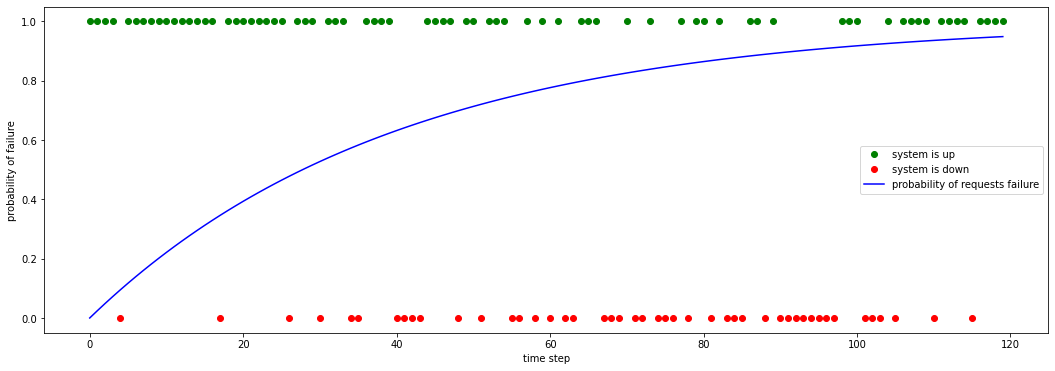

In [54]:
service_is_up = np.zeros(total_requests)
service_is_downs = np.zeros(total_requests)
failure_probability = np.zeros(total_requests)
for request_number in range(total_requests):
    failure_probability[request_number] = exponential_cdf(lmbda, request_number)
    status_code, info = flaky_client.call_status()
    if status_code == 200:
        print('ok', end=' ')
        service_is_up[request_number] = 1
        service_is_downs[request_number] = np.nan
    else:
        print(f"failed at { info['timeStep'] }", end=' ')
        service_is_up[request_number] = np.nan
        service_is_downs[request_number] = 0
    time.sleep(0.5)

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(range(total_requests), service_is_up, 'go', label='system is up')
ax.plot(range(total_requests), service_is_downs, 'ro', label='system is down')
ax.plot(range(total_requests), failure_probability, 'b', label='probability of requests failure')
ax.set_xlabel('time step')  # Add an x-label to the axes.
ax.set_ylabel('probability of failure')  # Add a y-label to the axes.
ax.legend()